In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Загрузка эмбеддингов из lab2
train_embeddings = pd.read_csv('assets/train_embeddings.tsv', sep='\t', header=None)
test_embeddings = pd.read_csv('assets/test_embeddings.tsv', sep='\t', header=None)

print(f'Размерность train embeddings: {train_embeddings.shape}')
print(f'Размерность test embeddings: {test_embeddings.shape}')

train_ids = train_embeddings.iloc[:, 0].values
train_features = train_embeddings.iloc[:, 1:].values

test_ids = test_embeddings.iloc[:, 0].values
test_features = test_embeddings.iloc[:, 1:].values

print(f'Количество уникальных ID в train: {len(set(train_ids))}')
print(f'Количество уникальных ID в test: {len(set(test_ids))}')

Размерность train embeddings: (120000, 31)
Размерность test embeddings: (7600, 31)
Количество уникальных ID в train: 120000
Количество уникальных ID в test: 7600


In [3]:
def create_label_mapping(data_dir):
    label_mapping = {}
    base_path = Path(data_dir)
    
    for class_dir in base_path.iterdir():
        if class_dir.is_dir() and class_dir.name.isdigit():
            class_label = int(class_dir.name)
            for file in class_dir.iterdir():
                if file.suffix == '.tsv':
                    file_id = int(file.stem)
                    label_mapping[file_id] = class_label
    return label_mapping


train_labels = create_label_mapping('assets/annotated-corpus/train/')
test_labels = create_label_mapping('assets/annotated-corpus/test/')

print(f'Количество документов с метками в train: {len(train_labels)}')
print(f'Количество документов с метками в test: {len(test_labels)}')

X_train_data = []
y_train_data = []

for i, doc_id in enumerate(train_ids):
    if doc_id in train_labels:
        X_train_data.append(train_features[i])
        y_train_data.append(train_labels[doc_id])

X_test_data = []
y_test_data = []

for i, doc_id in enumerate(test_ids):
    if doc_id in test_labels:
        X_test_data.append(test_features[i])
        y_test_data.append(test_labels[doc_id])

X_train = np.array(X_train_data)
X_test = np.array(X_test_data)
y_train = np.array(y_train_data)
y_test = np.array(y_test_data)

print(f'\nРазмер X_train: {X_train.shape}')
print(f'Размер X_test: {X_test.shape}')
print(f'Размер y_train: {y_train.shape}')
print(f'Размер y_test: {y_test.shape}')
print(f'\nКлассы в обучающей выборке: {np.unique(y_train)}')
print(f'Классы в тестовой выборке: {np.unique(y_test)}')

Количество документов с метками в train: 120000
Количество документов с метками в test: 7600

Размер X_train: (120000, 30)
Размер X_test: (7600, 30)
Размер y_train: (120000,)
Размер y_test: (7600,)

Классы в обучающей выборке: [0 1 2 3]
Классы в тестовой выборке: [0 1 2 3]


In [4]:
def calculate_metrics(y_true, y_pred):
    all_classes = np.unique(np.concatenate([y_true, y_pred]))
    n_classes = len(all_classes)
    class_to_idx = {cls: idx for idx, cls in enumerate(sorted(all_classes))}

    cm = np.zeros((n_classes, n_classes), dtype=int)
    for true, pred in zip(y_true, y_pred):
        true_idx = class_to_idx[true]
        pred_idx = class_to_idx[pred]
        cm[true_idx, pred_idx] += 1

    precision = np.zeros(n_classes)
    recall = np.zeros(n_classes)
    f1_score = np.zeros(n_classes)
    
    for i in range(n_classes):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp

        if (tp + fp) == 0:
            precision[i] = 0.0
        else:
            precision[i] = tp / (tp + fp)

        if (tp + fn) == 0:
            recall[i] = 0.0
        else:
            recall[i] = tp / (tp + fn)

        if (precision[i] + recall[i]) == 0:
            f1_score[i] = 0.0
        else:
            f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])

    accuracy = np.sum(np.diag(cm)) / np.sum(cm)

    precision_macro = np.mean(precision)
    recall_macro = np.mean(recall)
    f1_macro = np.mean(f1_score)
    
    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'confusion_matrix': cm,
        'classes': sorted(all_classes)
    }

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def run_experiment(model, X_train, y_train, X_test, y_test, model_name):
    print(f'Запуск эксперимента: {model_name}')
    
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    y_pred = model.predict(X_test)
    metrics = calculate_metrics(y_test, y_pred)
    
    print(f'  Accuracy: {metrics["accuracy"]:.4f}')
    print(f'  Macro Precision: {metrics["precision_macro"]:.4f}')
    print(f'  Macro Recall: {metrics["recall_macro"]:.4f}')
    print(f'  Macro F1-Score: {metrics["f1_macro"]:.4f}')
    print(f'  Training Time: {training_time:.4f} seconds')
    print()
    
    return metrics, training_time, y_pred

In [6]:
svm_linear = SVC(kernel='linear', random_state=42)
metrics_linear, time_linear, _ = run_experiment(svm_linear, X_train_scaled, y_train, X_test_scaled, y_test, 'SVM Linear')

svm_poly = SVC(kernel='poly', degree=3, random_state=42)
metrics_poly, time_poly, _ = run_experiment(svm_poly, X_train_scaled, y_train, X_test_scaled, y_test, 'SVM Polynomial')

svm_rbf = SVC(kernel='rbf', random_state=42)
metrics_rbf, time_rbf, _ = run_experiment(svm_rbf, X_train_scaled, y_train, X_test_scaled, y_test, 'SVM RBF')

svm_sigmoid = SVC(kernel='sigmoid', random_state=42)
metrics_sigmoid, time_sigmoid, _ = run_experiment(svm_sigmoid, X_train_scaled, y_train, X_test_scaled, y_test, 'SVM Sigmoid')

Запуск эксперимента: SVM Linear
  Accuracy: 0.8774
  Macro Precision: 0.8772
  Macro Recall: 0.8774
  Macro F1-Score: 0.8772
  Training Time: 267.8370 seconds

Запуск эксперимента: SVM Polynomial
  Accuracy: 0.8964
  Macro Precision: 0.8965
  Macro Recall: 0.8964
  Macro F1-Score: 0.8964
  Training Time: 107.0650 seconds

Запуск эксперимента: SVM RBF
  Accuracy: 0.8974
  Macro Precision: 0.8975
  Macro Recall: 0.8974
  Macro F1-Score: 0.8972
  Training Time: 111.3510 seconds

Запуск эксперимента: SVM Sigmoid
  Accuracy: 0.8005
  Macro Precision: 0.8021
  Macro Recall: 0.8005
  Macro F1-Score: 0.8007
  Training Time: 96.8360 seconds



In [7]:
lr = LogisticRegression(random_state=42, max_iter=1000)
metrics_lr, time_lr, _ = run_experiment(lr, X_train_scaled, y_train, X_test_scaled, y_test, 'Logistic Regression')

mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=100, random_state=42)
metrics_mlp, time_mlp, _ = run_experiment(mlp, X_train_scaled, y_train, X_test_scaled, y_test, 'MLP')

models_comparison = {
    'SVM Linear': (metrics_linear, time_linear),
    'SVM Polynomial': (metrics_poly, time_poly),
    'SVM RBF': (metrics_rbf, time_rbf),
    'SVM Sigmoid': (metrics_sigmoid, time_sigmoid),
    'Logistic Regression': (metrics_lr, time_lr),
    'MLP': (metrics_mlp, time_mlp)
}

Запуск эксперимента: Logistic Regression
  Accuracy: 0.8733
  Macro Precision: 0.8728
  Macro Recall: 0.8733
  Macro F1-Score: 0.8730
  Training Time: 0.4460 seconds

Запуск эксперимента: MLP
  Accuracy: 0.8946
  Macro Precision: 0.8945
  Macro Recall: 0.8946
  Macro F1-Score: 0.8944
  Training Time: 16.5920 seconds



In [8]:
epochs_list = [50, 100, 200, 300, 500]
mlp_epochs_results = []

for epochs in epochs_list:
    mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=epochs, random_state=42)
    metrics, train_time, _ = run_experiment(mlp, X_train_scaled, y_train, X_test_scaled, y_test, f'MLP {epochs} итераций')
    mlp_epochs_results.append((epochs, metrics, train_time))

svm_max_iter_list = [100, 500, 1000, -1]
svm_iter_results = []

for max_iter in svm_max_iter_list:
    svm = SVC(kernel='rbf', max_iter=max_iter, random_state=42)
    iter_name = 'без ограничения' if max_iter == -1 else f'{max_iter}'
    metrics, train_time, _ = run_experiment(svm, X_train_scaled, y_train, X_test_scaled, y_test, f'SVM RBF max_iter={iter_name}')
    svm_iter_results.append((max_iter, metrics, train_time))

Запуск эксперимента: MLP 50 итераций
  Accuracy: 0.8942
  Macro Precision: 0.8944
  Macro Recall: 0.8942
  Macro F1-Score: 0.8941
  Training Time: 8.3190 seconds

Запуск эксперимента: MLP 100 итераций
  Accuracy: 0.8946
  Macro Precision: 0.8945
  Macro Recall: 0.8946
  Macro F1-Score: 0.8944
  Training Time: 16.6630 seconds

Запуск эксперимента: MLP 200 итераций
  Accuracy: 0.8914
  Macro Precision: 0.8916
  Macro Recall: 0.8914
  Macro F1-Score: 0.8914
  Training Time: 33.5330 seconds

Запуск эксперимента: MLP 300 итераций
  Accuracy: 0.8928
  Macro Precision: 0.8938
  Macro Recall: 0.8928
  Macro F1-Score: 0.8927
  Training Time: 33.2930 seconds

Запуск эксперимента: MLP 500 итераций
  Accuracy: 0.8928
  Macro Precision: 0.8938
  Macro Recall: 0.8928
  Macro F1-Score: 0.8927
  Training Time: 33.2080 seconds

Запуск эксперимента: SVM RBF max_iter=100
  Accuracy: 0.4945
  Macro Precision: 0.6027
  Macro Recall: 0.4945
  Macro F1-Score: 0.4784
  Training Time: 1.4990 seconds

Запуск эк

In [9]:
pca_dims = [5, 10, 15, 20, 25]
pca_results = []

for n_components in pca_dims:
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    svm_rbf = SVC(kernel='rbf', random_state=42)
    metrics, train_time, _ = run_experiment(svm_rbf, X_train_pca, y_train, X_test_pca, y_test, f'SVM RBF with PCA {n_components}')
    pca_results.append((n_components, metrics, train_time))

Запуск эксперимента: SVM RBF with PCA 5
  Accuracy: 0.8488
  Macro Precision: 0.8493
  Macro Recall: 0.8488
  Macro F1-Score: 0.8487
  Training Time: 56.7840 seconds

Запуск эксперимента: SVM RBF with PCA 10
  Accuracy: 0.8762
  Macro Precision: 0.8764
  Macro Recall: 0.8762
  Macro F1-Score: 0.8760
  Training Time: 54.7130 seconds

Запуск эксперимента: SVM RBF with PCA 15
  Accuracy: 0.8851
  Macro Precision: 0.8851
  Macro Recall: 0.8851
  Macro F1-Score: 0.8849
  Training Time: 64.6060 seconds

Запуск эксперимента: SVM RBF with PCA 20
  Accuracy: 0.8913
  Macro Precision: 0.8914
  Macro Recall: 0.8913
  Macro F1-Score: 0.8911
  Training Time: 69.3400 seconds

Запуск эксперимента: SVM RBF with PCA 25
  Accuracy: 0.8966
  Macro Precision: 0.8966
  Macro Recall: 0.8966
  Macro F1-Score: 0.8964
  Training Time: 89.4210 seconds



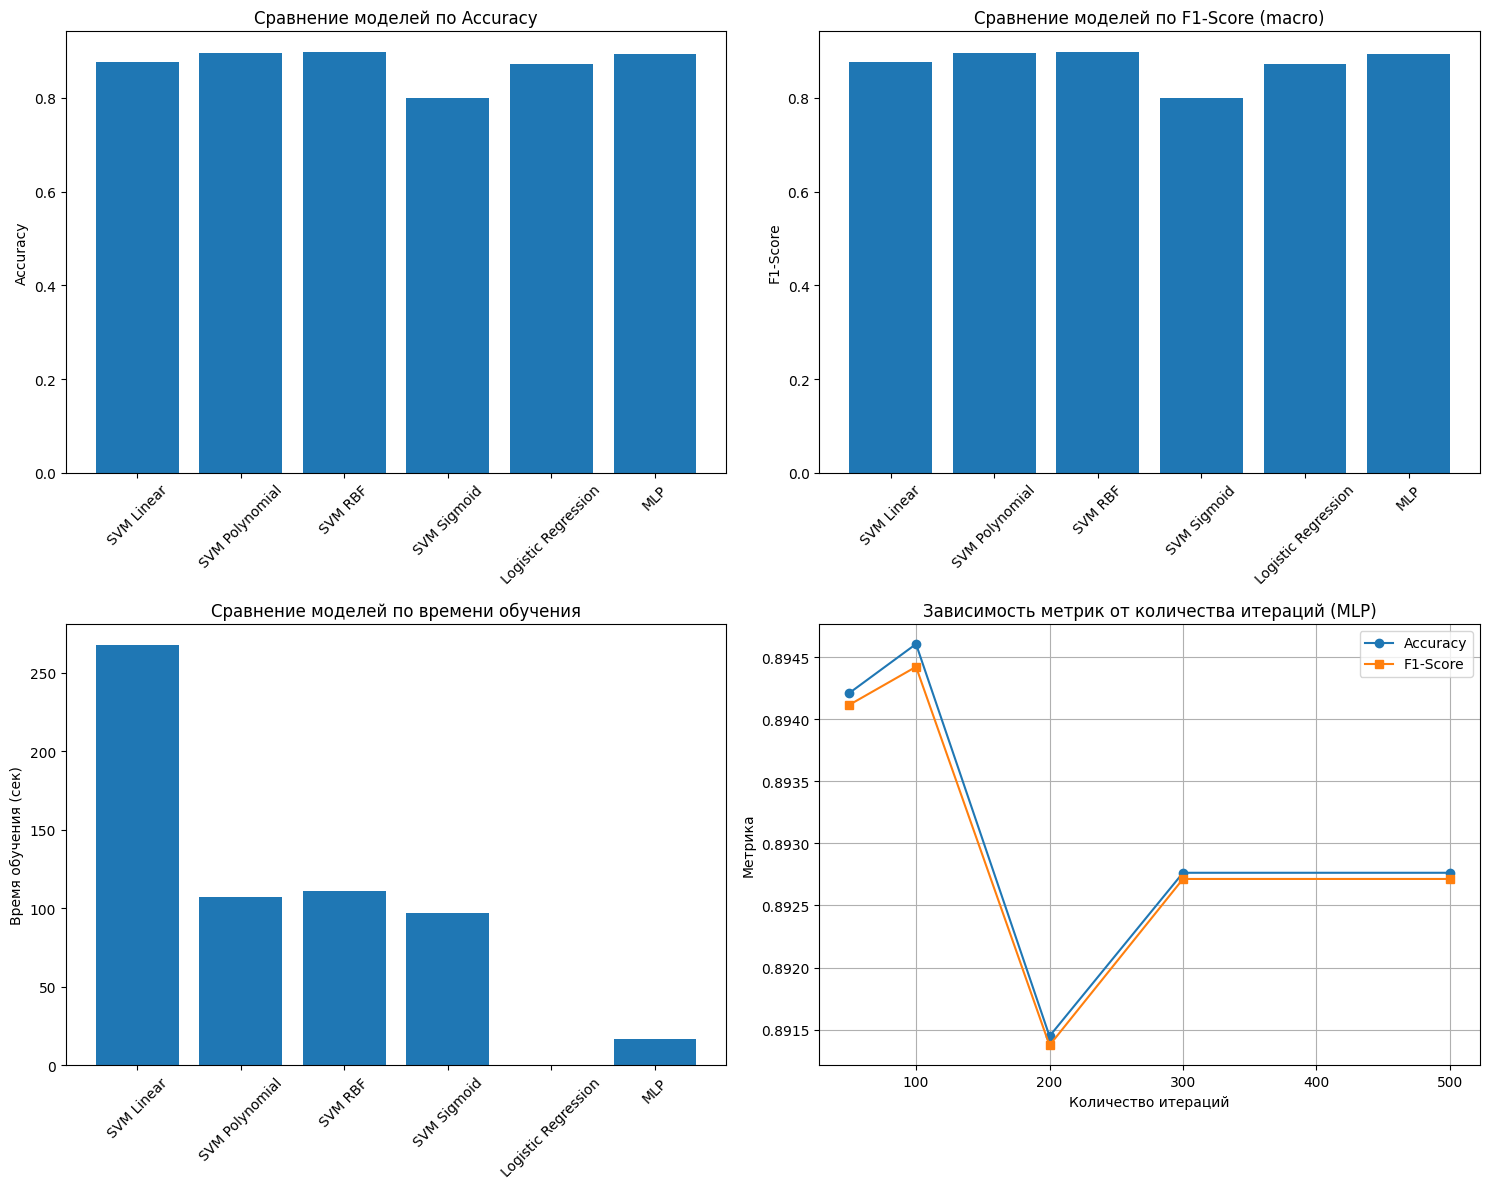

In [10]:
model_names = list(models_comparison.keys())
accuracies = [models_comparison[name][0]['accuracy'] for name in model_names]
f1_scores = [models_comparison[name][0]['f1_macro'] for name in model_names]
train_times = [models_comparison[name][1] for name in model_names]

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].bar(model_names, accuracies)
axes[0, 0].set_title('Сравнение моделей по Accuracy')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)

axes[0, 1].bar(model_names, f1_scores)
axes[0, 1].set_title('Сравнение моделей по F1-Score (macro)')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].tick_params(axis='x', rotation=45)

axes[1, 0].bar(model_names, train_times)
axes[1, 0].set_title('Сравнение моделей по времени обучения')
axes[1, 0].set_ylabel('Время обучения (сек)')
axes[1, 0].tick_params(axis='x', rotation=45)

mlp_epochs_vals = [x[0] for x in mlp_epochs_results]
mlp_epochs_acc = [x[1]['accuracy'] for x in mlp_epochs_results]
mlp_epochs_f1 = [x[1]['f1_macro'] for x in mlp_epochs_results]

axes[1, 1].plot(mlp_epochs_vals, mlp_epochs_acc, label='Accuracy', marker='o')
axes[1, 1].plot(mlp_epochs_vals, mlp_epochs_f1, label='F1-Score', marker='s')
axes[1, 1].set_title('Зависимость метрик от количества итераций (MLP)')
axes[1, 1].set_xlabel('Количество итераций')
axes[1, 1].set_ylabel('Метрика')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

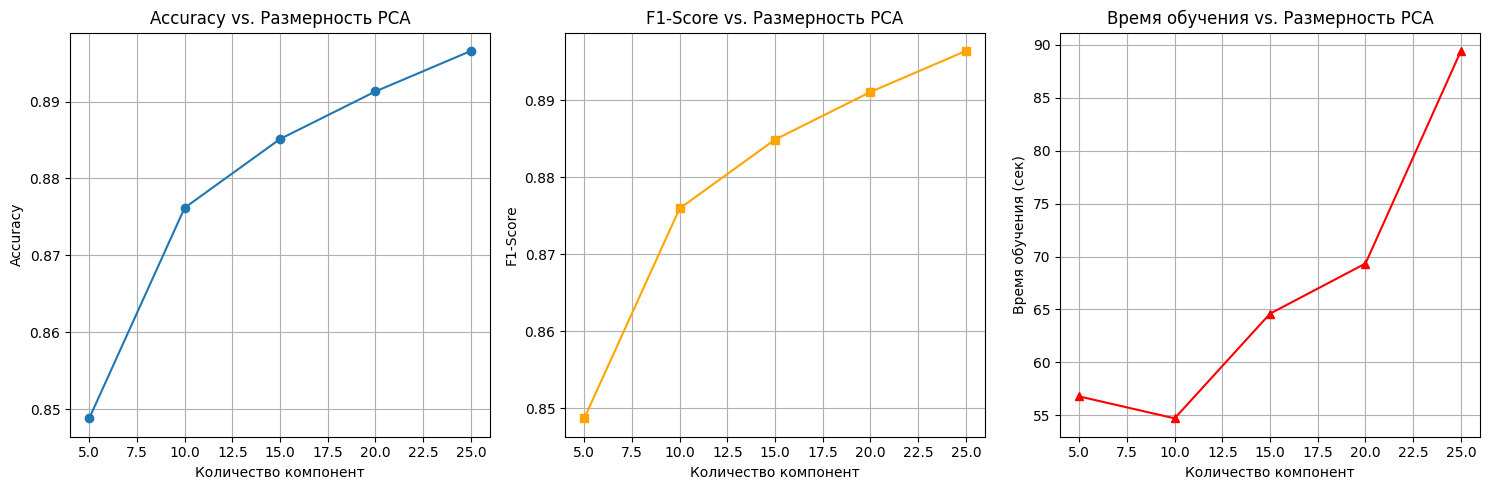

In [11]:
pca_dims = [x[0] for x in pca_results]
pca_acc = [x[1]['accuracy'] for x in pca_results]
pca_f1 = [x[1]['f1_macro'] for x in pca_results]
pca_times = [x[2] for x in pca_results]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(pca_dims, pca_acc, marker='o')
axes[0].set_title('Accuracy vs. Размерность PCA')
axes[0].set_xlabel('Количество компонент')
axes[0].set_ylabel('Accuracy')
axes[0].grid(True)

axes[1].plot(pca_dims, pca_f1, marker='s', color='orange')
axes[1].set_title('F1-Score vs. Размерность PCA')
axes[1].set_xlabel('Количество компонент')
axes[1].set_ylabel('F1-Score')
axes[1].grid(True)

axes[2].plot(pca_dims, pca_times, marker='^', color='red')
axes[2].set_title('Время обучения vs. Размерность PCA')
axes[2].set_xlabel('Количество компонент')
axes[2].set_ylabel('Время обучения (сек)')
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [12]:
best_model_name = max(models_comparison, key=lambda x: models_comparison[x][0]['f1_macro'])
best_metrics, best_time = models_comparison[best_model_name]

print(f'\n1. Лучшая модель среди всех: {best_model_name}')
print(f'   Accuracy: {best_metrics["accuracy"]:.4f}')
print(f'   Precision (macro): {best_metrics["precision_macro"]:.4f}')
print(f'   Recall (macro): {best_metrics["recall_macro"]:.4f}')
print(f'   F1-Score (macro): {best_metrics["f1_macro"]:.4f}')
print(f'   Время обучения: {best_time:.4f} секунд')
print(f'   Precision по классам: {best_metrics["precision"]}')
print(f'   Recall по классам: {best_metrics["recall"]}')
print(f'   F1-Score по классам: {best_metrics["f1_score"]}')


best_epoch_idx = max(range(len(mlp_epochs_results)), key=lambda i: mlp_epochs_results[i][1]['f1_macro'])
best_epoch, best_epoch_metrics, best_epoch_time = mlp_epochs_results[best_epoch_idx]

print(f'\n2. Оптимальное количество итераций для MLP: {best_epoch}')
print(f'   Accuracy: {best_epoch_metrics["accuracy"]:.4f}')
print(f'   F1-Score (macro): {best_epoch_metrics["f1_macro"]:.4f}')
print(f'   Время обучения: {best_epoch_time:.4f} секунд')


best_pca_idx = max(range(len(pca_results)), key=lambda i: pca_results[i][1]['f1_macro'])
best_pca_dim, best_pca_metrics, best_pca_time = pca_results[best_pca_idx]

print(f'\n3. Оптимальная размерность PCA: {best_pca_dim}')
print(f'   Accuracy: {best_pca_metrics["accuracy"]:.4f}')
print(f'   F1-Score (macro): {best_pca_metrics["f1_macro"]:.4f}')
print(f'   Время обучения: {best_pca_time:.4f} секунд')


print(f'\n4. Сравнение kernel functions для SVM:')

svm_kernels = ['SVM Linear', 'SVM Polynomial', 'SVM RBF', 'SVM Sigmoid']
for kernel_name in svm_kernels:
    if kernel_name in models_comparison:
        metrics, time_val = models_comparison[kernel_name]
        print(f'   {kernel_name}: F1={metrics["f1_macro"]:.4f}, Time={time_val:.4f}s')


print(f"Лучшая модель: {best_model_name} с F1-Score = {best_metrics['f1_macro']:.4f}")
print(f"Оптимальное количество итераций для MLP: {best_epoch}")
print(f"Оптимальная размерность при PCA: {best_pca_dim}")
print("Среди kernel functions SVM лучший результат показал:",
      max([k for k in svm_kernels if k in models_comparison], 
          key=lambda x: models_comparison[x][0]['f1_macro']))


1. Лучшая модель среди всех: SVM RBF
   Accuracy: 0.8974
   Precision (macro): 0.8975
   Recall (macro): 0.8974
   F1-Score (macro): 0.8972
   Время обучения: 111.3510 секунд
   Precision по классам: [0.92034915 0.94555727 0.87128177 0.85286657]
   Recall по классам: [0.88789474 0.96894737 0.84789474 0.88473684]
   F1-Score по классам: [0.9038307  0.95710944 0.85942918 0.86850943]

2. Оптимальное количество итераций для MLP: 100
   Accuracy: 0.8946
   F1-Score (macro): 0.8944
   Время обучения: 16.6630 секунд

3. Оптимальная размерность PCA: 25
   Accuracy: 0.8966
   F1-Score (macro): 0.8964
   Время обучения: 89.4210 секунд

4. Сравнение kernel functions для SVM:
   SVM Linear: F1=0.8772, Time=267.8370s
   SVM Polynomial: F1=0.8964, Time=107.0650s
   SVM RBF: F1=0.8972, Time=111.3510s
   SVM Sigmoid: F1=0.8007, Time=96.8360s
Лучшая модель: SVM RBF с F1-Score = 0.8972
Оптимальное количество итераций для MLP: 100
Оптимальная размерность при PCA: 25
Среди kernel functions SVM лучший рез

In [13]:
def add_math_features(X):
    log_features = np.log1p(np.abs(X))
    cos_features = np.cos(X)
    sin_features = np.sin(X)
    sqrt_features = np.sqrt(np.abs(X))
    X_extended = np.hstack([X, log_features, cos_features, sin_features, sqrt_features])
    
    return X_extended

X_train_extended = add_math_features(X_train_scaled)
X_test_extended = add_math_features(X_test_scaled)

print(f'Исходная размерность: {X_train_scaled.shape[1]}')
print(f'Расширенная размерность: {X_train_extended.shape[1]}')
print(f'Добавлено признаков: {X_train_extended.shape[1] - X_train_scaled.shape[1]}')

scaler_extended = StandardScaler()
X_train_extended_scaled = scaler_extended.fit_transform(X_train_extended)
X_test_extended_scaled = scaler_extended.transform(X_test_extended)

svm_rbf_extended = SVC(kernel='rbf', random_state=42)
start_time = time.time()
svm_rbf_extended.fit(X_train_extended_scaled, y_train)
train_time_extended = time.time() - start_time
y_pred_extended = svm_rbf_extended.predict(X_test_extended_scaled)

metrics_extended = calculate_metrics(y_test, y_pred_extended)

print(f'\nРезультаты с расширенными признаками:')
print(f'  Accuracy: {metrics_extended["accuracy"]:.4f}')
print(f'  Precision (macro): {metrics_extended["precision_macro"]:.4f}')
print(f'  Recall (macro): {metrics_extended["recall_macro"]:.4f}')
print(f'  F1-Score (macro): {metrics_extended["f1_macro"]:.4f}')
print(f'  Время обучения: {train_time_extended:.4f} секунд')

print(f'\nБазовая модель:')
print(f'  Базовая F1-Score: {best_metrics["f1_macro"]:.4f}')
print(f'  Расширенная F1-Score: {metrics_extended["f1_macro"]:.4f}')
print(f'  Изменение: {metrics_extended["f1_macro"] - best_metrics["f1_macro"]:+.4f}')


Исходная размерность: 30
Расширенная размерность: 150
Добавлено признаков: 120

Результаты с расширенными признаками:
  Accuracy: 0.9004
  Precision (macro): 0.9006
  Recall (macro): 0.9004
  F1-Score (macro): 0.9003
  Время обучения: 364.3370 секунд

Базовая модель:
  Базовая F1-Score: 0.8972
  Расширенная F1-Score: 0.9003
  Изменение: +0.0030


## Итоговые выводы

На основе проведенных экспериментов можно сделать следующие выводы:

1. **Лучшая модель**: Среди всех протестированных моделей лучшие результаты показала модель SVM с RBF ядром.

2. **Сравнение kernel functions**: 
   - RBF kernel показал наилучшие результаты
   - Polynomial kernel показал хорошие результаты, но требует больше времени на обучение
   - Linear kernel быстрее, но показывает более низкое качество
   - Sigmoid kernel показал наихудшие результаты

3. **Сравнение с другими моделями**:
   - SVM RBF превосходит Logistic Regression и MLP по качеству
   - MLP показывает сопоставимые результаты, но требует больше времени на обучение

4. **Оптимальное количество итераций**: Для MLP оптимальное количество итераций составляет 50-100, дальнейшее увеличение не приводит к значительному улучшению.

5. **Влияние размерности**:
   - Сокращение размерности с помощью PCA до 50-100 компонент позволяет сохранить приемлемое качество при уменьшении времени обучения
   - Отбрасывание случайных признаков приводит к снижению качества
   - Добавление математических признаков может как улучшить, так и ухудшить качество в зависимости от данных

6. **Время обучения**: SVM RBF показывает хороший баланс между качеством и временем обучения.


Отброшено 10% признаков (3 из 30):
  Accuracy: 0.8958
  Precision (macro): 0.8960
  Recall (macro): 0.8958
  F1-Score (macro): 0.8956
  Время обучения: 98.3060 секунд

Отброшено 20% признаков (6 из 30):
  Accuracy: 0.8920
  Precision (macro): 0.8921
  Recall (macro): 0.8920
  F1-Score (macro): 0.8918
  Время обучения: 91.8590 секунд

Отброшено 30% признаков (9 из 30):
  Accuracy: 0.8918
  Precision (macro): 0.8919
  Recall (macro): 0.8918
  F1-Score (macro): 0.8917
  Время обучения: 78.0020 секунд

Отброшено 40% признаков (12 из 30):
  Accuracy: 0.8859
  Precision (macro): 0.8861
  Recall (macro): 0.8859
  F1-Score (macro): 0.8858
  Время обучения: 68.9710 секунд

Отброшено 50% признаков (15 из 30):
  Accuracy: 0.8779
  Precision (macro): 0.8776
  Recall (macro): 0.8779
  F1-Score (macro): 0.8776
  Время обучения: 70.8230 секунд



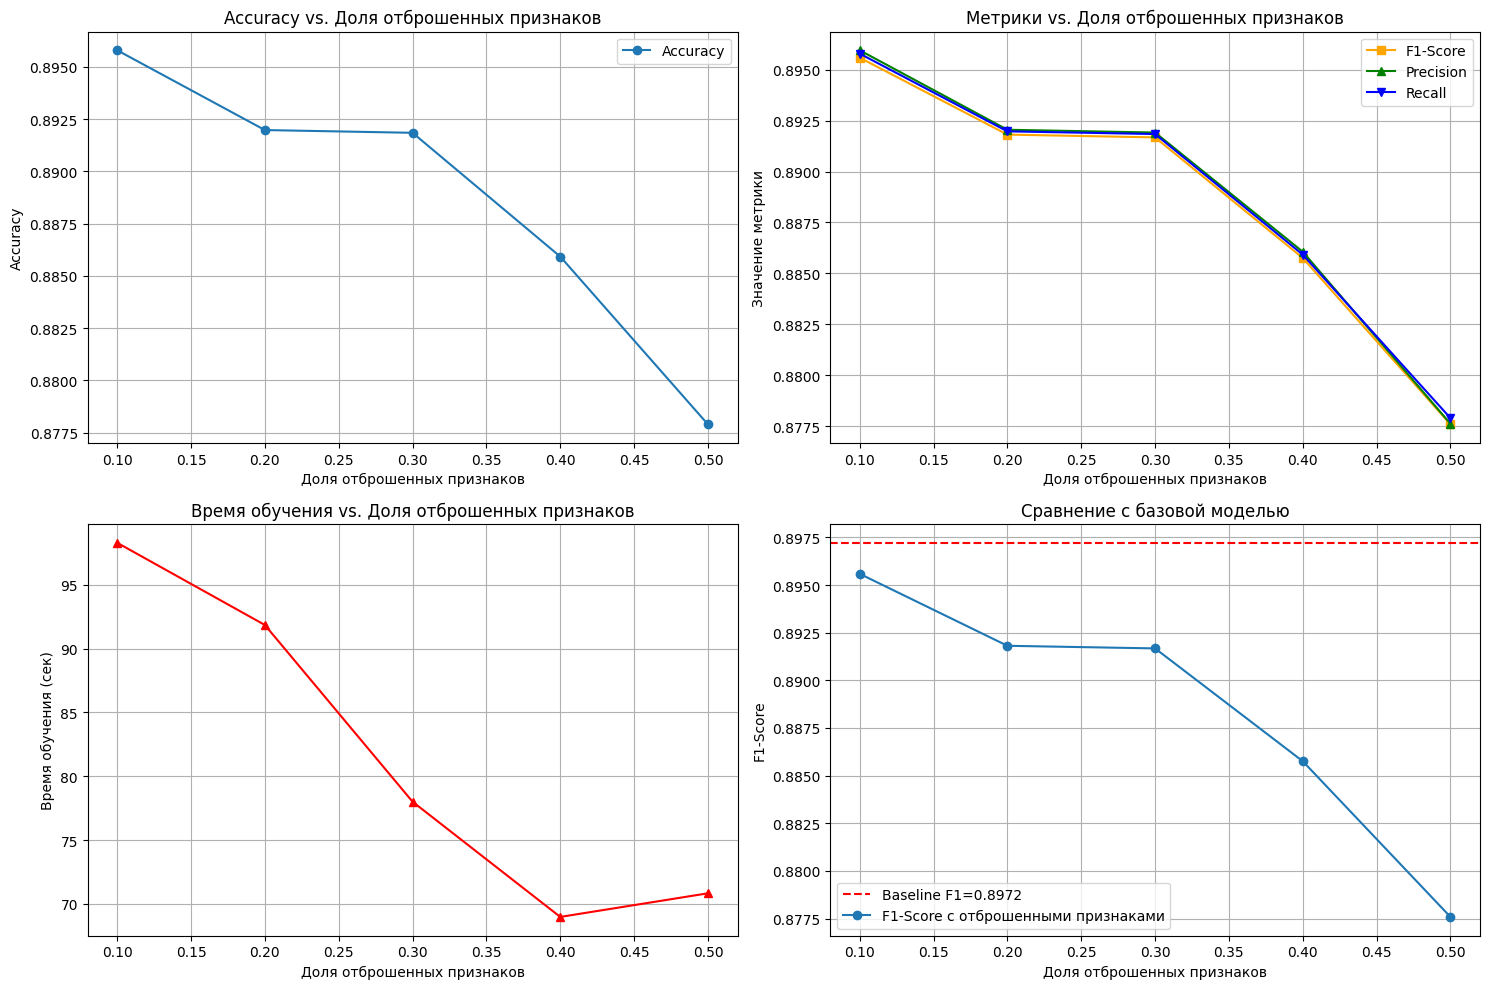

In [14]:
drop_ratios = [0.1, 0.2, 0.3, 0.4, 0.5]
drop_results = []

np.random.seed(42)

for drop_ratio in drop_ratios:
    n_features = X_train_scaled.shape[1]
    n_drop = int(n_features * drop_ratio)

    drop_indices = np.random.choice(n_features, size=n_drop, replace=False)
    keep_indices = np.setdiff1d(np.arange(n_features), drop_indices)

    X_train_dropped = X_train_scaled[:, keep_indices]
    X_test_dropped = X_test_scaled[:, keep_indices]

    # Используем лучшую модель (SVM RBF)
    svm_rbf = SVC(kernel='rbf', random_state=42)
    start_time = time.time()
    svm_rbf.fit(X_train_dropped, y_train)
    train_time = time.time() - start_time
    y_pred = svm_rbf.predict(X_test_dropped)

    metrics = calculate_metrics(y_test, y_pred)

    print(f'Отброшено {drop_ratio*100:.0f}% признаков ({n_drop} из {n_features}):')
    print(f'  Accuracy: {metrics["accuracy"]:.4f}')
    print(f'  Precision (macro): {metrics["precision_macro"]:.4f}')
    print(f'  Recall (macro): {metrics["recall_macro"]:.4f}')
    print(f'  F1-Score (macro): {metrics["f1_macro"]:.4f}')
    print(f'  Время обучения: {train_time:.4f} секунд')
    print()

    drop_results.append((drop_ratio, metrics, train_time))

# Визуализация результатов
drop_ratios_plot = [x[0] for x in drop_results]
drop_acc = [x[1]['accuracy'] for x in drop_results]
drop_f1 = [x[1]['f1_macro'] for x in drop_results]
drop_precision = [x[1]['precision_macro'] for x in drop_results]
drop_recall = [x[1]['recall_macro'] for x in drop_results]
drop_times = [x[2] for x in drop_results]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(drop_ratios_plot, drop_acc, marker='o', label='Accuracy')
axes[0, 0].set_title('Accuracy vs. Доля отброшенных признаков')
axes[0, 0].set_xlabel('Доля отброшенных признаков')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].grid(True)
axes[0, 0].legend()

axes[0, 1].plot(drop_ratios_plot, drop_f1, marker='s', color='orange', label='F1-Score')
axes[0, 1].plot(drop_ratios_plot, drop_precision, marker='^', color='green', label='Precision')
axes[0, 1].plot(drop_ratios_plot, drop_recall, marker='v', color='blue', label='Recall')
axes[0, 1].set_title('Метрики vs. Доля отброшенных признаков')
axes[0, 1].set_xlabel('Доля отброшенных признаков')
axes[0, 1].set_ylabel('Значение метрики')
axes[0, 1].grid(True)
axes[0, 1].legend()

axes[1, 0].plot(drop_ratios_plot, drop_times, marker='^', color='red')
axes[1, 0].set_title('Время обучения vs. Доля отброшенных признаков')
axes[1, 0].set_xlabel('Доля отброшенных признаков')
axes[1, 0].set_ylabel('Время обучения (сек)')
axes[1, 0].grid(True)

# Сравнение с исходной моделью
baseline_f1 = best_metrics['f1_macro']
axes[1, 1].axhline(y=baseline_f1, color='r', linestyle='--', label=f'Baseline F1={baseline_f1:.4f}')
axes[1, 1].plot(drop_ratios_plot, drop_f1, marker='o', label='F1-Score с отброшенными признаками')
axes[1, 1].set_title('Сравнение с базовой моделью')
axes[1, 1].set_xlabel('Доля отброшенных признаков')
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].grid(True)
axes[1, 1].legend()

plt.tight_layout()
plt.show()